In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from PIL import Image
import json
import random
import os
!nvidia-smi

Wed Aug  7 15:11:49 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.99                 Driver Version: 555.99         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   46C    P3             12W /   45W |       0MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
n_epochs = 10   # Number of optimization epochs
n_layers = 5    # Number of random layers

SAVE_PATH = "../data"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

In [3]:
train_json = "C:/Users/gunsu/Documents/fraunhofer-qml/kaggle/train/train.json"

with open(train_json, 'r') as json_file:
    train_data_json = json.load(json_file)

In [4]:
label_names = ["good weld", "burn through", "contamination", "lack of fusion", "misalignment", "lack of penetration"]
labels = [0, 1, 2, 3, 4, 5]
one_hot_encoding = tf.keras.utils.to_categorical(labels, num_classes=6)
label_count = [0, 0, 0, 0, 0, 0]

In [5]:
for l in train_data_json:
    label_count[train_data_json[l]] += 1
    
label_count

[8758, 1783, 6325, 4028, 2953, 2819]

In [6]:
all_data = []
image_size = (256, 256)
label_count = [0, 0, 0, 0, 0, 0]

In [7]:
def load_data(path):
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if(os.path.isdir(folder_path)):
            for img_name in os.listdir(folder_path):
                
                img_path = os.path.join(folder_path, img_name)
                key_name = folder + '/' + img_name
                label = train_data_json[key_name]
                
                if(label_count[label] > 20):
                    continue
                    
                label_count[label] += 1
                image = Image.open(img_path).resize(image_size)
                image = tf.convert_to_tensor(image)
                all_data.append((image, one_hot_encoding[label]))
                
                if(len(all_data)%10==0):
                    print(f"Total images loaded : {len(all_data)}, Label count : {label_count}", end = '\r')

In [8]:
load_data("C:/Users/gunsu/Documents/fraunhofer-qml/kaggle/train")

In [9]:
random.shuffle(all_data)

In [10]:
X = []
y = []

for data in all_data:
    X.append(data[0])
    y.append(data[1])

In [11]:
rand_num = np.random.randint(low = 0, high = len(all_data))
X[rand_num], y[rand_num]

(<tf.Tensor: shape=(256, 256), dtype=uint8, numpy=
 array([[11, 11, 11, ...,  6,  6,  6],
        [11, 11, 11, ...,  7,  6,  6],
        [12, 12, 12, ...,  9,  8,  8],
        ...,
        [41, 44, 44, ..., 49, 47, 50],
        [42, 42, 40, ..., 47, 48, 52],
        [42, 41, 40, ..., 49, 50, 53]], dtype=uint8)>,
 array([0., 0., 0., 0., 0., 1.]))

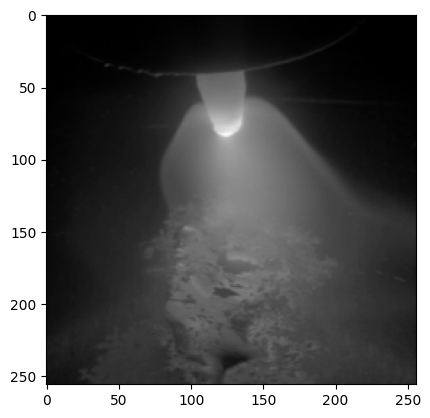

Label : contamination


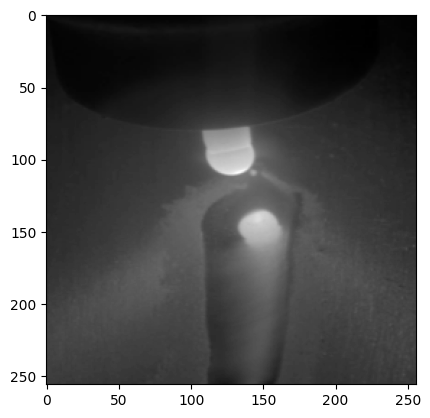

Label : good weld


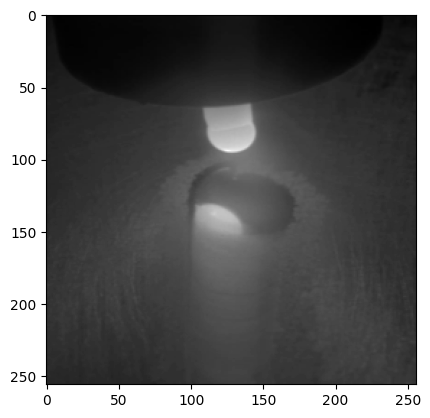

Label : lack of penetration


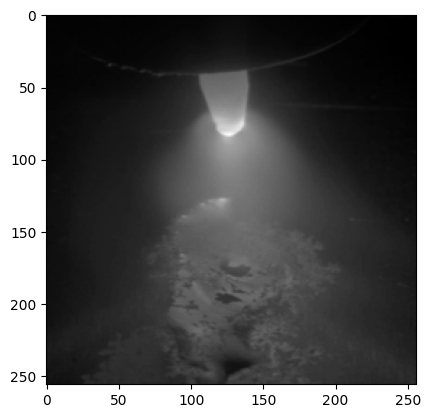

Label : contamination


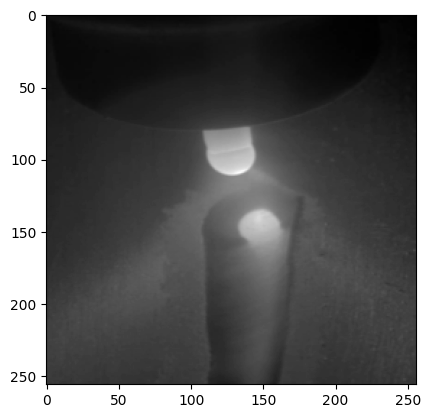

Label : good weld


In [12]:
for _ in range(5):
    rand_img = np.random.randint(low = 0, high = len(X))
    plt.imshow(X[rand_img], cmap='gray')
    plt.show()
    print(f"Label : {label_names[np.argmax(y[rand_img])]}")

In [13]:
total_data = len(X)
X_train, y_train = X[:int(total_data*0.8)], y[:int(total_data*0.8)]
X_test, y_test = X[int(total_data*0.8):], y[int(total_data*0.8):]

In [14]:
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

In [15]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(TensorShape([100, 256, 256]),
 TensorShape([100, 6]),
 TensorShape([26, 256, 256]),
 TensorShape([26, 6]))

In [16]:
X_train = tf.reshape(X_train, shape=(len(X_train), 256, 256, 1))
X_test = tf.reshape(X_test, shape=(len(X_test), 256, 256, 1))

X_train.shape, y_train.shape

(TensorShape([100, 256, 256, 1]), TensorShape([100, 6]))

In [17]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [18]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

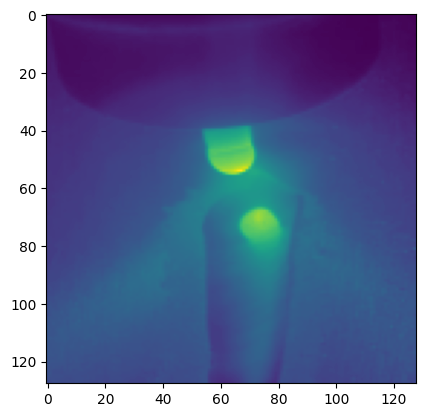

In [19]:
test_image = X_train[3]
test_resized = keras.layers.Resizing(128,128)(test_image)
plt.imshow(test_image)
plt.imshow(test_resized)

plt.show()

In [20]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(X_train):
        print("{}/{}        ".format(idx + 1, len(X_train)), end="\r")
        # Resize (256,256) -> (128,128) 
        img = keras.layers.Resizing(128,128)(img)
        # Quantum convolution layer
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(X_test):
        print("{}/{}        ".format(idx + 1, len(X_test)), end="\r")
        # Resize (256,256) -> (128,128) 
        img = keras.layers.Resizing(128,128)(img)
        # Quantum convolution layer
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:


c:\Users\gunsu\AppData\Local\Programs\Python\Python39\lib\site-packages\pennylane\math\utils.py:228: UserWarning: Contains tensors of types {'tensorflow', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


100/100        
Quantum pre-processing of test images:


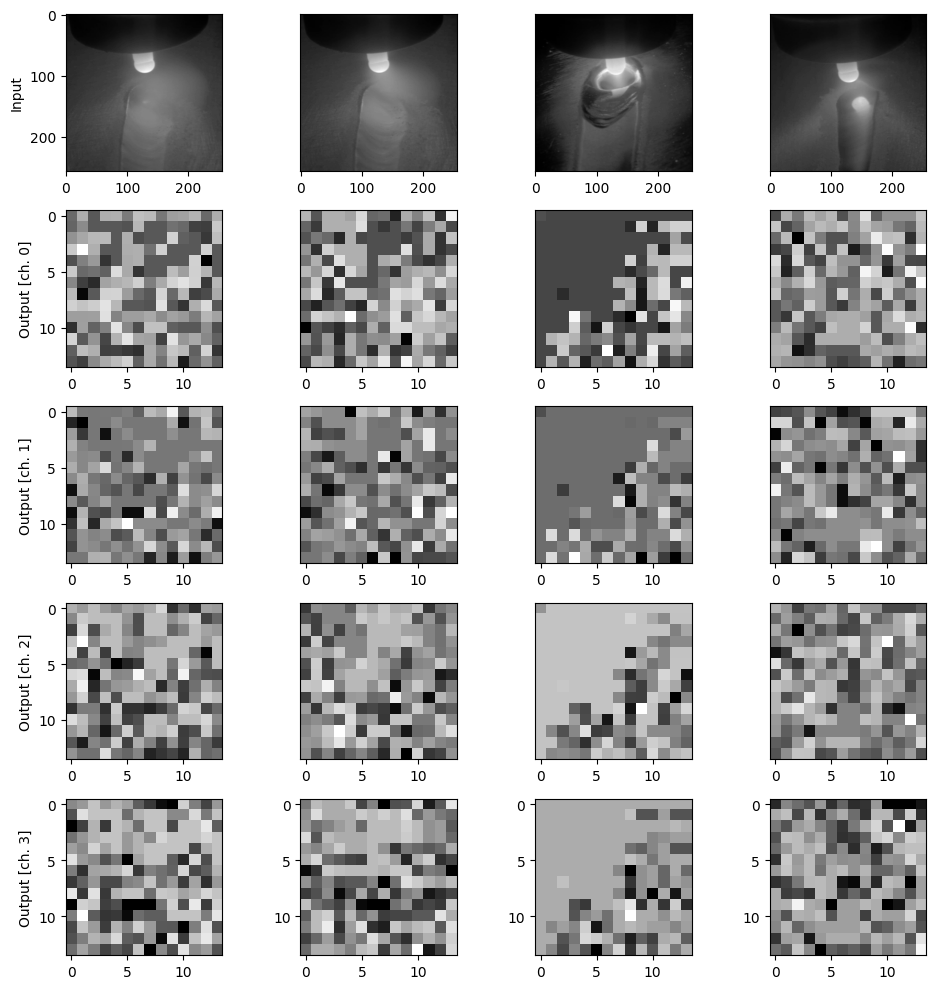

In [21]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(X_train[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [22]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(16, activation="relu"),
        keras.layers.Dense(16, activation="relu"),
        keras.layers.Dense(6, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [23]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    y_train,
    validation_data=(q_test_images, y_test),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/10
25/25 - 1s - 27ms/step - accuracy: 0.1600 - loss: 0.6740 - val_accuracy: 0.1923 - val_loss: 0.6594
Epoch 2/10
25/25 - 0s - 3ms/step - accuracy: 0.2800 - loss: 0.5962 - val_accuracy: 0.1923 - val_loss: 0.6067
Epoch 3/10
25/25 - 0s - 2ms/step - accuracy: 0.3600 - loss: 0.5092 - val_accuracy: 0.1923 - val_loss: 0.5529
Epoch 4/10
25/25 - 0s - 2ms/step - accuracy: 0.4200 - loss: 0.4407 - val_accuracy: 0.1923 - val_loss: 0.5150
Epoch 5/10
25/25 - 0s - 2ms/step - accuracy: 0.5000 - loss: 0.3975 - val_accuracy: 0.3077 - val_loss: 0.4912
Epoch 6/10
25/25 - 0s - 2ms/step - accuracy: 0.6100 - loss: 0.3613 - val_accuracy: 0.3077 - val_loss: 0.4725
Epoch 7/10
25/25 - 0s - 3ms/step - accuracy: 0.6500 - loss: 0.3265 - val_accuracy: 0.3462 - val_loss: 0.4550
Epoch 8/10
25/25 - 0s - 3ms/step - accuracy: 0.7100 - loss: 0.2908 - val_accuracy: 0.3462 - val_loss: 0.4362
Epoch 9/10
25/25 - 0s - 2ms/step - accuracy: 0.7900 - loss: 0.2558 - val_accuracy: 0.4231 - val_loss: 0.4164
Epoch 10/10
25/25 

In [25]:
c_model = MyModel()

c_history = c_model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/10
25/25 - 1s - 30ms/step - accuracy: 0.1800 - loss: 75.5562 - val_accuracy: 0.1923 - val_loss: 0.6891
Epoch 2/10
25/25 - 0s - 4ms/step - accuracy: 0.1700 - loss: 0.6847 - val_accuracy: 0.1154 - val_loss: 0.6800
Epoch 3/10
25/25 - 0s - 4ms/step - accuracy: 0.1800 - loss: 0.6755 - val_accuracy: 0.1154 - val_loss: 0.6707
Epoch 4/10
25/25 - 0s - 5ms/step - accuracy: 0.1300 - loss: 0.6665 - val_accuracy: 0.1923 - val_loss: 0.6616
Epoch 5/10
25/25 - 0s - 3ms/step - accuracy: 0.1600 - loss: 0.6577 - val_accuracy: 0.1923 - val_loss: 0.6529
Epoch 6/10
25/25 - 0s - 4ms/step - accuracy: 0.1600 - loss: 0.6492 - val_accuracy: 0.1923 - val_loss: 0.6444
Epoch 7/10
25/25 - 0s - 4ms/step - accuracy: 0.1600 - loss: 0.6410 - val_accuracy: 0.1923 - val_loss: 0.6363
Epoch 8/10
25/25 - 0s - 4ms/step - accuracy: 0.1600 - loss: 0.6331 - val_accuracy: 0.1923 - val_loss: 0.6284
Epoch 9/10
25/25 - 0s - 4ms/step - accuracy: 0.1600 - loss: 0.6255 - val_accuracy: 0.1923 - val_loss: 0.6209
Epoch 10/10
25/25

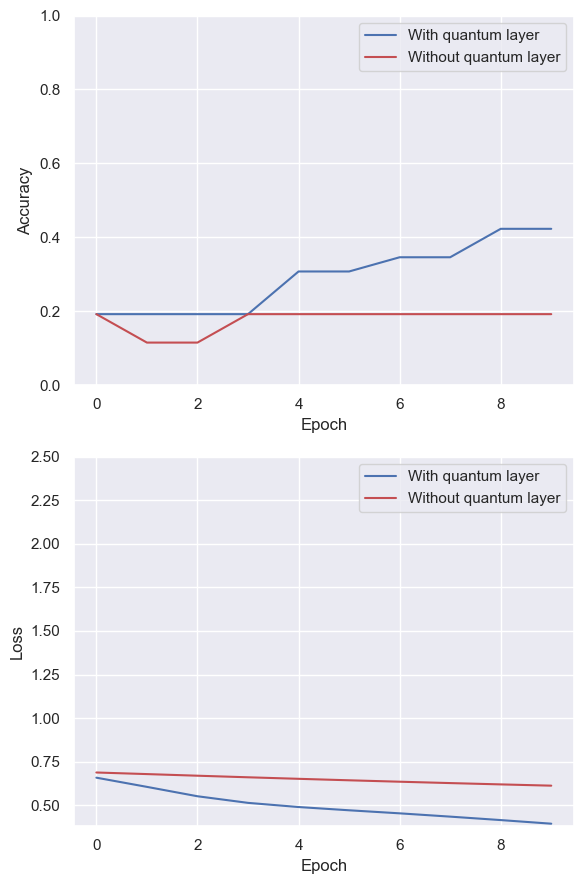

In [26]:
import seaborn as sns
sns.set(style='darkgrid')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-b", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-r", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-b", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-r", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()